
# Análise COVID-19 (Casos Semanais × Google Trends Mensais) — Notebook Corrigido

Este notebook alinha corretamente os **casos semanais** (planilha `sp_2022.xlsx`) com os **dados mensais do Google Trends** (`sãopaulo_timeline.csv`).

- Converte **Ano_Semana (ex: 1/2022)** → data (segunda-feira da semana ISO).
- Agrega **casos semanais** em **soma mensal**.
- Mantém o **Google Trends** como índice mensal (média/valor já vem mensal).
- Junta os dois datasets para permitir análise de correlação e gráficos.


In [1]:

import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

# === Arquivos de entrada (já ajustados) ===
DATA_PATHS = {
    2020: r"C:\Users\Faculdade\Downloads\covid_sp\sp_2020.xlsx",
    2021: r"C:\Users\Faculdade\Downloads\covid_sp\sp_2021.xlsx",
    2022: r"C:\Users\Faculdade\Downloads\covid_sp\sp_2022.xlsx",
    2023: r"C:\Users\Faculdade\Downloads\covid_sp\sp_2023.xlsx",
    2024: r"C:\Users\Faculdade\Downloads\covid_sp\sp_2024.xlsx",
    2025: r"C:\Users\Faculdade\Downloads\covid_sp\sp_2025.xlsx",
}

TRENDS_PATH = r"C:\Users\Faculdade\Downloads\covid_sp\sãopaulo_timeline.csv"

In [2]:
# === Função: semanal → mensal (com índice de tempo) ===
def weekly_cases_to_monthly(path):
    df = pd.read_excel(path)
    df[["Semana", "Ano"]] = df["Ano_Semana"].str.split("/", expand=True)
    df["Ano"] = df["Ano"].astype(int)
    df["Semana"] = df["Semana"].astype(int)
    df["Data"] = pd.to_datetime(
        df["Ano"].astype(str) + "-W" + df["Semana"].astype(str) + "-1", 
        format="%G-W%V-%u"
    )
    df["Mes"] = df["Data"].dt.to_period("M").dt.to_timestamp()
    
    out = df.groupby("Mes")["Casos Novos"].sum().reset_index()
    out.rename(columns={"Casos Novos": "Casos_Mensais"}, inplace=True)
    out.set_index("Mes", inplace=True)   # <<< índice = tempo
    return out

# === Carregar todos os anos ===
all_cases = [weekly_cases_to_monthly(path) for path in DATA_PATHS.values()]
cases_full = pd.concat(all_cases).sort_index()

# === Google Trends ===
def monthly_trends(path):
    df = pd.read_csv(path, skiprows=1)
    date_col = df.columns[0]
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df.rename(columns={date_col: "Mes", df.columns[1]: "Trends"}, inplace=True)
    df.set_index("Mes", inplace=True)   # <<< índice = tempo
    return df

trends = monthly_trends(TRENDS_PATH)

# === Juntar no mesmo período ===
aligned = cases_full.join(trends, how="inner")

print(aligned.head())

            Casos_Mensais  Trends
Mes                              
2020-03-01           4466      36
2020-04-01          26708      88
2020-05-01          75968      68
2020-06-01         205388      56
2020-07-01         239788      52


In [3]:
m_cases = cases_full   # já é a junção de todos os anos
m_trends = monthly_trends(TRENDS_PATH)

aligned = m_cases.join(m_trends, how="inner")

print("Formato final:", aligned.shape)
aligned.head()


Formato final: (68, 2)


,Casos_Mensais,Trends
Mes,,
2020-03-01,4466,36
2020-04-01,26708,88
2020-05-01,75968,68
2020-06-01,205388,56
2020-07-01,239788,52


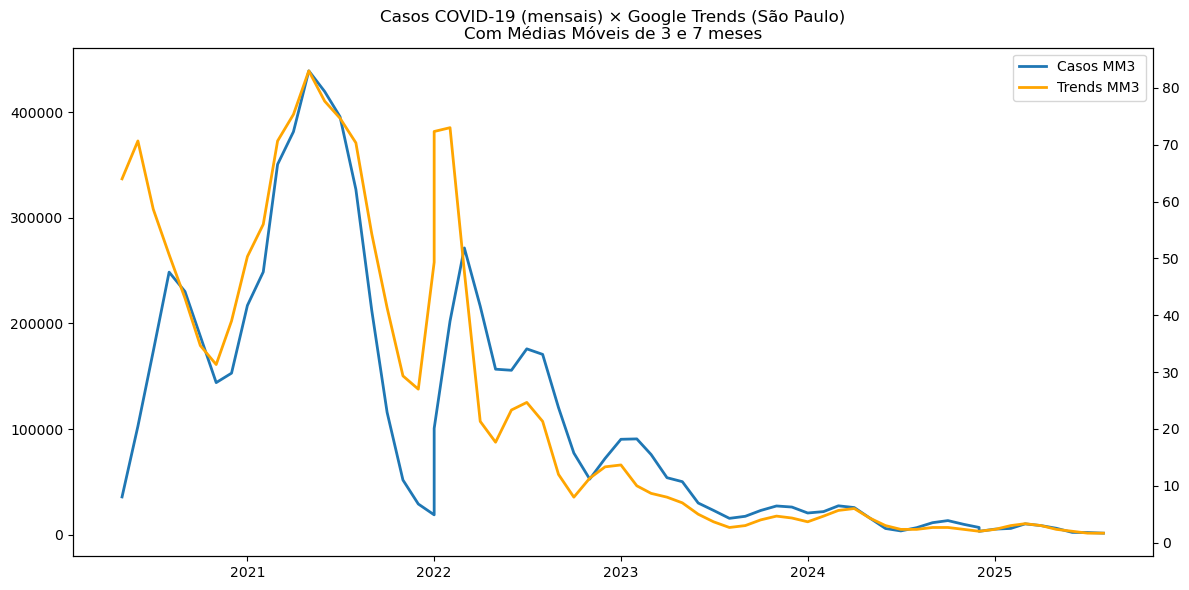

In [4]:
# === Calcular médias móveis ===
aligned["Casos_Mensais_MM3"] = aligned["Casos_Mensais"].rolling(window=3).mean()
aligned["Casos_Mensais_MM7"] = aligned["Casos_Mensais"].rolling(window=7).mean()
aligned["Trends_MM3"] = aligned["Trends"].rolling(window=3).mean()
aligned["Trends_MM7"] = aligned["Trends"].rolling(window=7).mean()

# === Plot ===
fig, ax1 = plt.subplots(figsize=(12,6))

# Casos
ax1.plot(aligned.index, aligned["Casos_Mensais_MM3"], 
         label="Casos MM3", color="tab:blue", linewidth=2)

# Trends
ax2 = ax1.twinx()
ax2.plot(aligned.index, aligned["Trends_MM3"], 
         label="Trends MM3", color="orange", linewidth=2)


# Título e layout
plt.title("Casos COVID-19 (mensais) × Google Trends (São Paulo)\nCom Médias Móveis de 3 e 7 meses")
fig.tight_layout()

# Legendas combinadas
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.show()


In [5]:
corr = aligned["Casos_Mensais"].corr(aligned["Trends"], method="pearson")
print(f"Correlação Casos_Mensais × Trends: {corr:.3f}")


Correlação Casos_Mensais × Trends: 0.740


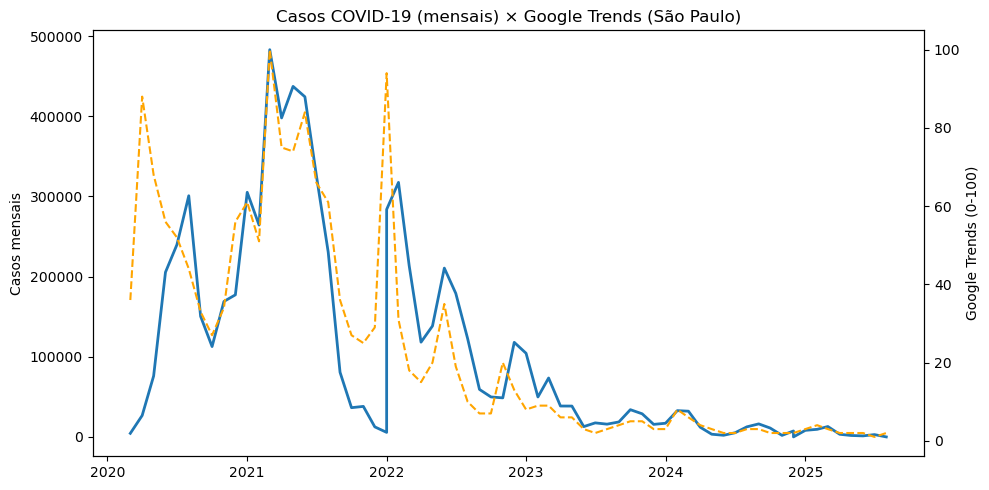

In [6]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(aligned.index, aligned["Casos_Mensais"], label="Casos (mensal)", linewidth=2)
ax1.set_ylabel("Casos mensais")

ax2 = ax1.twinx()
ax2.plot(aligned.index, aligned["Trends"], color="orange", linestyle="--", label="Trends")
ax2.set_ylabel("Google Trends (0-100)")

plt.title("Casos COVID-19 (mensais) × Google Trends (São Paulo)")
fig.tight_layout()
plt.show()


In [7]:
# Média móvel (3 meses)
aligned["Casos_MM3"] = aligned["Casos_Mensais"].rolling(3).mean()
aligned["Trends_MM3"] = aligned["Trends"].rolling(3).mean()

# Mediana
median_cases = aligned["Casos_Mensais"].median()
median_trends = aligned["Trends"].median()

# Variância
var_cases = aligned["Casos_Mensais"].var()
var_trends = aligned["Trends"].var()

# Intervalo interquartil (IQR)
iqr_cases = aligned["Casos_Mensais"].quantile(0.75) - aligned["Casos_Mensais"].quantile(0.25)
iqr_trends = aligned["Trends"].quantile(0.75) - aligned["Trends"].quantile(0.25)

print(f"Mediana Casos: {median_cases}, Mediana Trends: {median_trends}")
print(f"Variância Casos: {var_cases}, Variância Trends: {var_trends}")
print(f"IQR Casos: {iqr_cases}, IQR Trends: {iqr_trends}")


Mediana Casos: 38268.0, Mediana Trends: 9.0
Variância Casos: 15926519710.371376, Variância Trends: 808.2467076382798
IQR Casos: 158618.0, IQR Trends: 33.0


In [8]:
# Já assumindo que 'aligned' tem:
# índice: Mes (DatetimeIndex)
# colunas: Casos_Mensais, Trends

import pandas as pd
import matplotlib.pyplot as plt

# Criar médias móveis para suavizar
aligned["Casos_MM3"] = aligned["Casos_Mensais"].rolling(3).mean()
aligned["Trends_MM3"] = aligned["Trends"].rolling(3).mean()

aligned["Casos_MM7"] = aligned["Casos_Mensais"].rolling(7).mean()
aligned["Trends_MM7"] = aligned["Trends"].rolling(7).mean()


In [9]:
# Correlação direta
corr_raw = aligned["Casos_Mensais"].corr(aligned["Trends"])
# Correlação média móvel 3 meses
corr_mm3 = aligned["Casos_MM3"].corr(aligned["Trends_MM3"])

print(f"Correlação direta: {corr_raw:.2f}")
print(f"Correlação média móvel 3 meses: {corr_mm3:.2f}")


Correlação direta: 0.74
Correlação média móvel 3 meses: 0.83


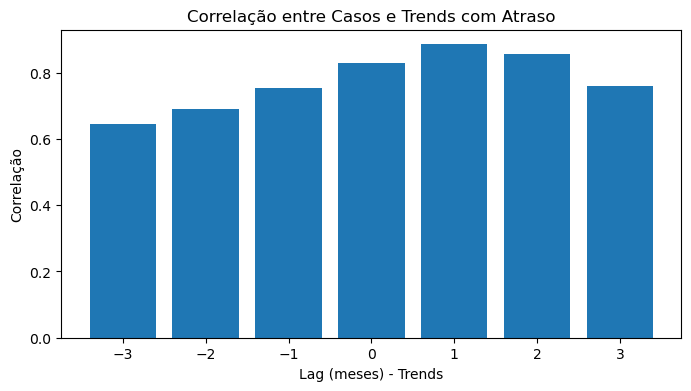

In [10]:
# Testar diferentes atrasos (lags) para Trends
lags = range(-3, 4)  # -3 a +3 meses
lag_corrs = []

for lag in lags:
    corr = aligned["Casos_MM3"].corr(aligned["Trends_MM3"].shift(lag))
    lag_corrs.append(corr)

# Plot lag correlation
plt.figure(figsize=(8,4))
plt.bar(lags, lag_corrs)
plt.xlabel("Lag (meses) - Trends")
plt.ylabel("Correlação")
plt.title("Correlação entre Casos e Trends com Atraso")
plt.show()


In [12]:
# Meses de maior impacto
mes_pico_casos = aligned["Casos_Mensais"].idxmax()
mes_pico_trends = aligned["Trends"].idxmax()

print("Mês com maior número de casos:", mes_pico_casos)
print("Mês com maior Trends:", mes_pico_trends)

# Percentil 90 para destacar meses críticos
casos_top10 = aligned["Casos_Mensais"].quantile(0.90)
trends_top10 = aligned["Trends"].quantile(0.90)

print("Casos acima do percentil 90:", casos_top10)
print("Trends acima do percentil 90:", trends_top10)


Mês com maior número de casos: 2021-03-01 00:00:00
Mês com maior Trends: 2021-03-01 00:00:00
Casos acima do percentil 90: 302058.2
Trends acima do percentil 90: 69.80000000000003


=== Estatísticas Descritivas ===
       Casos_Mensais      Trends  Casos_Mensais_MM3  Casos_Mensais_MM7  \
count      68.000000   68.000000          66.000000          62.000000   
mean   103010.676471   24.852941      105937.641414      108589.502304   
std    126200.315809   28.429680      118477.359680      106359.317361   
min         0.000000    1.000000        1395.333333        4526.714286   
25%     12404.500000    3.000000       15529.750000       17385.571429   
50%     38268.000000    9.000000       52156.833333       75420.142857   
75%    171022.500000   36.000000      172970.750000      175371.428571   
max    482937.000000  100.000000      439311.333333      376809.857143   

       Trends_MM3  Trends_MM7      Casos_MM3      Casos_MM7  
count   66.000000   62.000000      66.000000      62.000000  
mean    24.772727   24.304147  105937.641414  108589.502304  
std     26.353167   24.010794  118477.359680  106359.317361  
min      1.666667    2.285714    1395.333333    4526

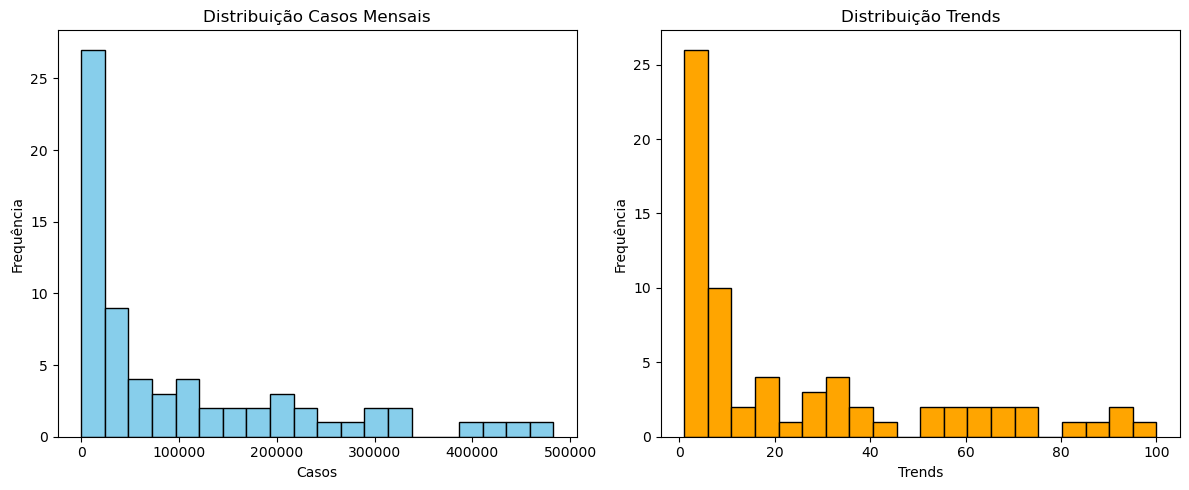

<Figure size 800x500 with 0 Axes>

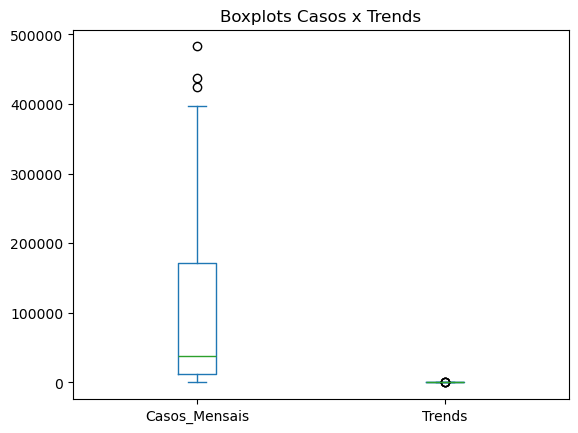

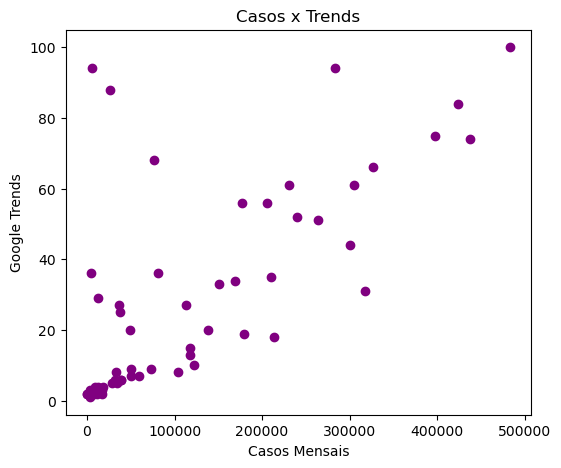

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# === Estatísticas descritivas básicas ===
desc = aligned.describe()
print("=== Estatísticas Descritivas ===")
print(desc)

# Mediana
median_cases = aligned["Casos_Mensais"].median()
median_trends = aligned["Trends"].median()
print(f"\nMediana Casos: {median_cases}")
print(f"Mediana Trends: {median_trends}")

# Variância
var_cases = aligned["Casos_Mensais"].var()
var_trends = aligned["Trends"].var()
print(f"\nVariância Casos: {var_cases}")
print(f"Variância Trends: {var_trends}")

# IQR (intervalo interquartil)
iqr_cases = aligned["Casos_Mensais"].quantile(0.75) - aligned["Casos_Mensais"].quantile(0.25)
iqr_trends = aligned["Trends"].quantile(0.75) - aligned["Trends"].quantile(0.25)
print(f"\nIQR Casos: {iqr_cases}")
print(f"IQR Trends: {iqr_trends}")

# Skewness e Curtose
skew_cases = skew(aligned["Casos_Mensais"])
kurt_cases = kurtosis(aligned["Casos_Mensais"])
skew_trends = skew(aligned["Trends"])
kurt_trends = kurtosis(aligned["Trends"])
print(f"\nSkewness Casos: {skew_cases}, Curtose Casos: {kurt_cases}")
print(f"Skewness Trends: {skew_trends}, Curtose Trends: {kurt_trends}")

# Picos (máximos)
peak_cases = aligned["Casos_Mensais"].idxmax()
peak_trends = aligned["Trends"].idxmax()
print(f"\nMês com maior número de casos: {peak_cases}")
print(f"Mês com maior Trends: {peak_trends}")

# Percentil 90
cases_p90 = aligned["Casos_Mensais"].quantile(0.90)
trends_p90 = aligned["Trends"].quantile(0.90)
print(f"\nCasos acima do percentil 90: {cases_p90}")
print(f"Trends acima do percentil 90: {trends_p90}")

# Histogramas
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(aligned["Casos_Mensais"], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribuição Casos Mensais")
plt.xlabel("Casos")
plt.ylabel("Frequência")

plt.subplot(1,2,2)
plt.hist(aligned["Trends"], bins=20, color='orange', edgecolor='black')
plt.title("Distribuição Trends")
plt.xlabel("Trends")
plt.ylabel("Frequência")

plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(8,5))
aligned[["Casos_Mensais","Trends"]].plot(kind="box")
plt.title("Boxplots Casos x Trends")
plt.show()

# Scatter plot
plt.figure(figsize=(6,5))
plt.scatter(aligned["Casos_Mensais"], aligned["Trends"], color='purple')
plt.xlabel("Casos Mensais")
plt.ylabel("Google Trends")
plt.title("Casos x Trends")
plt.show()


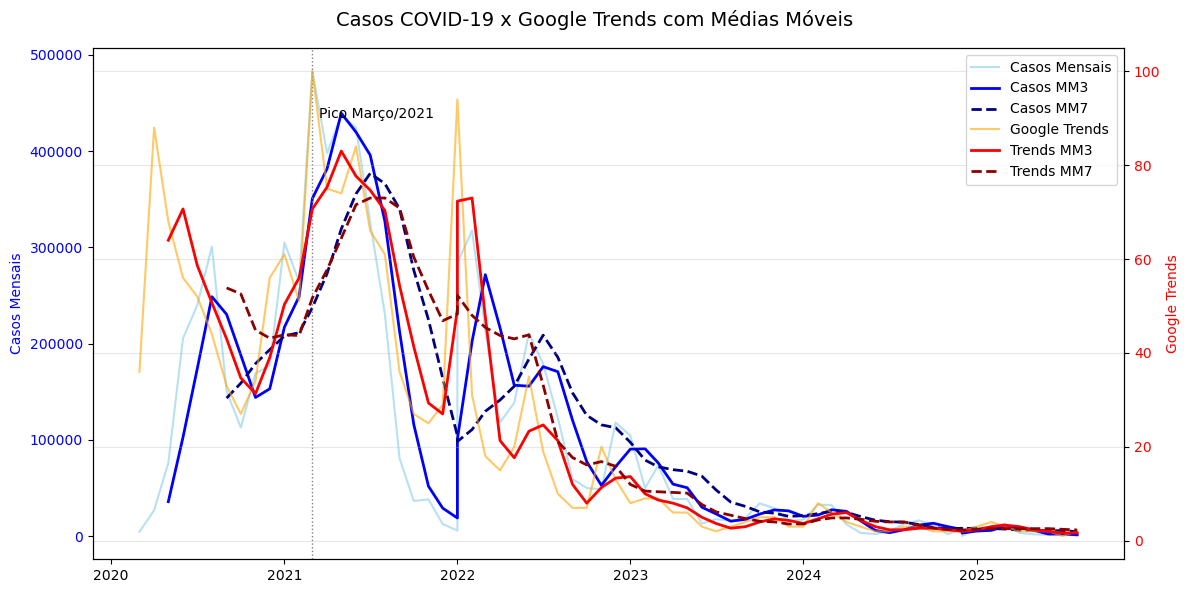

In [14]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Eixo 1: Casos
ax1.plot(aligned.index, aligned["Casos_Mensais"], 
         label="Casos Mensais", color="skyblue", alpha=0.6)
ax1.plot(aligned.index, aligned["Casos_MM3"], 
         label="Casos MM3", color="blue", linewidth=2)
ax1.plot(aligned.index, aligned["Casos_MM7"], 
         label="Casos MM7", color="navy", linestyle="--", linewidth=2)
ax1.set_ylabel("Casos Mensais", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Linha vertical pico
ax1.axvline(pd.to_datetime("2021-03-01"), color="gray", linestyle=":", linewidth=1)
ax1.text(pd.to_datetime("2021-03-15"), max(aligned["Casos_Mensais"])*0.9, 
         "Pico Março/2021", color="black")

# Eixo 2: Trends
ax2 = ax1.twinx()
ax2.plot(aligned.index, aligned["Trends"], 
         label="Google Trends", color="orange", alpha=0.6)
ax2.plot(aligned.index, aligned["Trends_MM3"], 
         label="Trends MM3", color="red", linewidth=2)
ax2.plot(aligned.index, aligned["Trends_MM7"], 
         label="Trends MM7", color="darkred", linestyle="--", linewidth=2)
ax2.set_ylabel("Google Trends", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Título e legendas
fig.suptitle("Casos COVID-19 x Google Trends com Médias Móveis", fontsize=14)
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


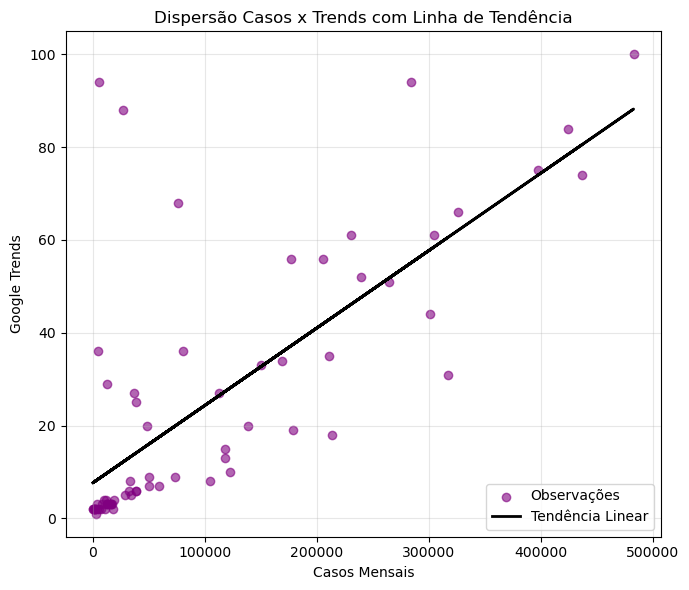

In [15]:
import numpy as np
from sklearn.linear_model import LinearRegression

plt.figure(figsize=(7,6))

# Dispersão
plt.scatter(aligned["Casos_Mensais"], aligned["Trends"], 
            color="purple", alpha=0.6, label="Observações")

# Ajuste de regressão linear
X = aligned["Casos_Mensais"].values.reshape(-1,1)
y = aligned["Trends"].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Linha de tendência
plt.plot(aligned["Casos_Mensais"], y_pred, 
         color="black", linewidth=2, label="Tendência Linear")

plt.xlabel("Casos Mensais")
plt.ylabel("Google Trends")
plt.title("Dispersão Casos x Trends com Linha de Tendência")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [16]:
from scipy.stats import pearsonr, spearmanr

# Pearson (linear)
pearson_corr, pearson_p = pearsonr(aligned["Casos_Mensais"], aligned["Trends"])

# Spearman (ordem/rank)
spearman_corr, spearman_p = spearmanr(aligned["Casos_Mensais"], aligned["Trends"])

print("=== Correlação Casos x Trends ===")
print(f"Pearson: {pearson_corr:.3f} (p={pearson_p:.3e})")
print(f"Spearman: {spearman_corr:.3f} (p={spearman_p:.3e})")


=== Correlação Casos x Trends ===
Pearson: 0.740 (p=5.466e-13)
Spearman: 0.801 (p=2.369e-16)


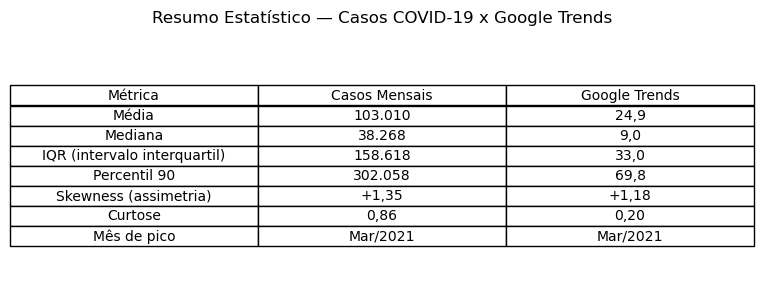

In [17]:
import matplotlib.pyplot as plt

# Dados do resumo
dados = [
    ["Média", "103.010", "24,9"],
    ["Mediana", "38.268", "9,0"],
    ["IQR (intervalo interquartil)", "158.618", "33,0"],
    ["Percentil 90", "302.058", "69,8"],
    ["Skewness (assimetria)", "+1,35", "+1,18"],
    ["Curtose", "0,86", "0,20"],
    ["Mês de pico", "Mar/2021", "Mar/2021"]
]

colunas = ["Métrica", "Casos Mensais", "Google Trends"]

# Criando a figura
fig, ax = plt.subplots(figsize=(8,3))
ax.axis("tight")
ax.axis("off")

# Criando tabela
tabela = ax.table(cellText=dados, colLabels=colunas, loc="center", cellLoc="center")

# Estilizando tabela
tabela.auto_set_font_size(False)
tabela.set_fontsize(10)
tabela.scale(1.2, 1.2)

# Título
plt.title("Resumo Estatístico — Casos COVID-19 x Google Trends", fontsize=12, pad=20)

plt.show()


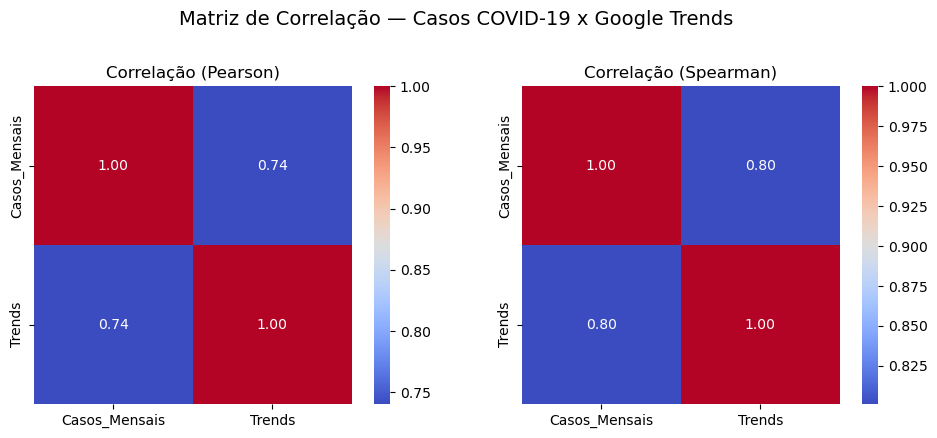

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlação Pearson
corr_pearson = aligned[["Casos_Mensais", "Trends"]].corr(method="pearson")

# Correlação Spearman
corr_spearman = aligned[["Casos_Mensais", "Trends"]].corr(method="spearman")

# Criando subplots
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Heatmap Pearson
sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap="coolwarm", 
            cbar=True, square=True, ax=axes[0])
axes[0].set_title("Correlação (Pearson)")

# Heatmap Spearman
sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap="coolwarm", 
            cbar=True, square=True, ax=axes[1])
axes[1].set_title("Correlação (Spearman)")

plt.suptitle("Matriz de Correlação — Casos COVID-19 x Google Trends", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


In [19]:
corr_spearman_raw = aligned["Casos_Mensais"].corr(aligned["Trends"], method="spearman")
corr_spearman_mm3 = aligned["Casos_MM3"].corr(aligned["Trends_MM3"], method="spearman")
print(f"Correlação Spearman direta: {corr_spearman_raw:.2f}")
print(f"Correlação Spearman média móvel 3 meses: {corr_spearman_mm3:.2f}")

Correlação Spearman direta: 0.80
Correlação Spearman média móvel 3 meses: 0.91


In [23]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

# 1. Teste de Estacionariedade (ADF Test)
# Se p-value > 0.05, a série não é estacionária e precisa ser diferenciada
print("ADF Test for Casos_Mensais:")
result_casos = adfuller(aligned["Casos_Mensais"].dropna())
print(f"p-value: {result_casos[1]:.3f}")

print("\nADF Test for Trends:")
result_trends = adfuller(aligned["Trends"].dropna())
print(f"p-value: {result_trends[1]:.3f}")

# Se não forem estacionárias, diferencie as séries
# Ex: aligned['Casos_diff'] = aligned['Casos_Mensais'].diff().dropna()
# Ex: aligned['Trends_diff'] = aligned['Trends'].diff().dropna()

# 2. Teste de Causalidade de Granger
# maxlag: número máximo de lags a testar
#df_granger = pd.DataFrame({'Casos': aligned['Casos_diff'], 'Trends': aligned['Trends_diff']}).dropna()
#grangercausalitytests(df_granger[['Casos', 'Trends']], maxlag=3, verbose=True)
#grangercausalitytests(df_granger[['Trends', 'Casos']], maxlag=3, verbose=True)

ADF Test for Casos_Mensais:
p-value: 0.206

ADF Test for Trends:
p-value: 0.629


In [34]:
from statsmodels.tsa.stattools import grangercausalitytests

def run_granger_test(data, max_lag, cause, effect):
    print(f"Teste de Granger: {cause} -> {effect}")
    results = grangercausalitytests(data, maxlag=max_lag, verbose=False)
    for lag in range(1, max_lag+1):
        test_res = results[lag][0]
        f_test = test_res['ssr_ftest']
        p_value = f_test[1]
        print(f"Lag {lag}: F-test p-valor = {p_value:.4f} {'(significativo)' if p_value < 0.05 else '(não significativo)'}")
    print("\n")

# Preparar os dados para os testes
df_granger = aligned[['Casos_diff', 'Trends_diff']].dropna()

# Testar se Trends_diff Granger-causa Casos_diff
run_granger_test(df_granger[['Casos_diff', 'Trends_diff']], max_lag=3, cause='Trends_diff', effect='Casos_diff')

# Testar se Casos_diff Granger-causa Trends_diff
run_granger_test(df_granger[['Trends_diff', 'Casos_diff']], max_lag=3, cause='Casos_diff', effect='Trends_diff')


Teste de Granger: Trends_diff -> Casos_diff
Lag 1: F-test p-valor = 0.0021 (significativo)
Lag 2: F-test p-valor = 0.0000 (significativo)
Lag 3: F-test p-valor = 0.0001 (significativo)


Teste de Granger: Casos_diff -> Trends_diff
Lag 1: F-test p-valor = 0.0017 (significativo)
Lag 2: F-test p-valor = 0.0249 (significativo)
Lag 3: F-test p-valor = 0.0194 (significativo)




C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


**Bidirecionalidade:**
Ambos os testes indicam que as séries se influenciam mutuamente. Ou seja, as variações no volume de buscas no Google Trends ajudam a prever as variações nos casos confirmados de COVID-19, e vice-versa.

**Potencial preditivo das buscas:**
O fato de que o volume de buscas Granger-causa os casos para lags de até 3 meses sugere que o interesse e a preocupação da população (medidos pelas buscas) podem antecipar o aumento dos casos. Isso é muito valioso para vigilância epidemiológica, pois permite identificar tendências antes que os casos sejam oficialmente reportados.

**Reação das buscas aos casos:**
A causalidade inversa indica que o aumento dos casos também gera aumento nas buscas, o que é esperado — quando a pandemia piora, as pessoas buscam mais informações.

**Força da relação:**
Os p-valores baixos (muito abaixo de 0.05) indicam que essas relações são estatisticamente significativas e não fruto do acaso.

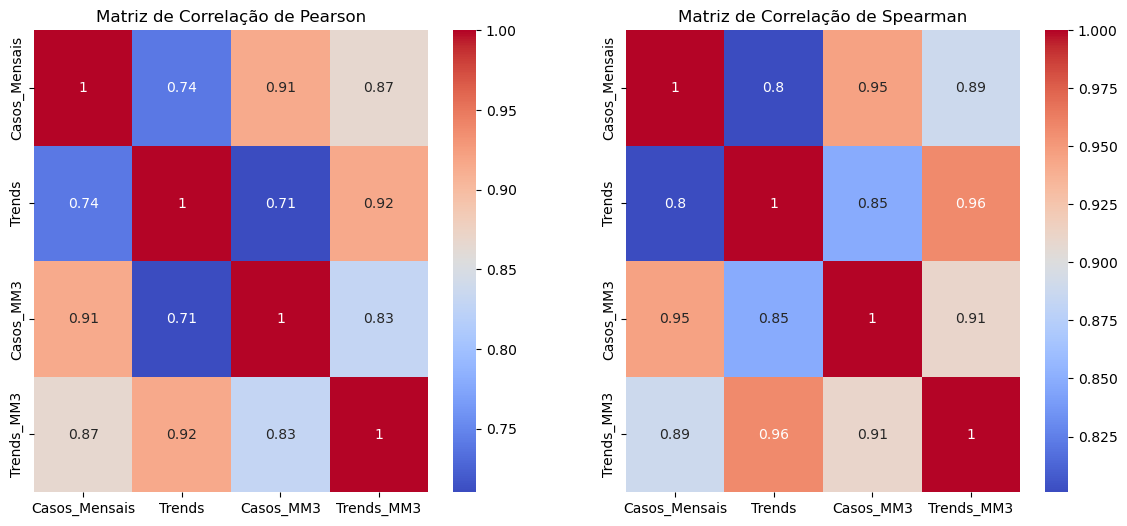

In [27]:
corr_matrix = aligned[['Casos_Mensais', 'Trends', 'Casos_MM3', 'Trends_MM3']].corr(method='pearson')
corr_spearman = aligned[['Casos_Mensais', 'Trends', 'Casos_MM3', 'Trends_MM3']].corr(method='spearman')

fig, axes = plt.subplots(1,2, figsize=(14,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Matriz de Correlação de Pearson')
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Matriz de Correlação de Spearman')
plt.show()

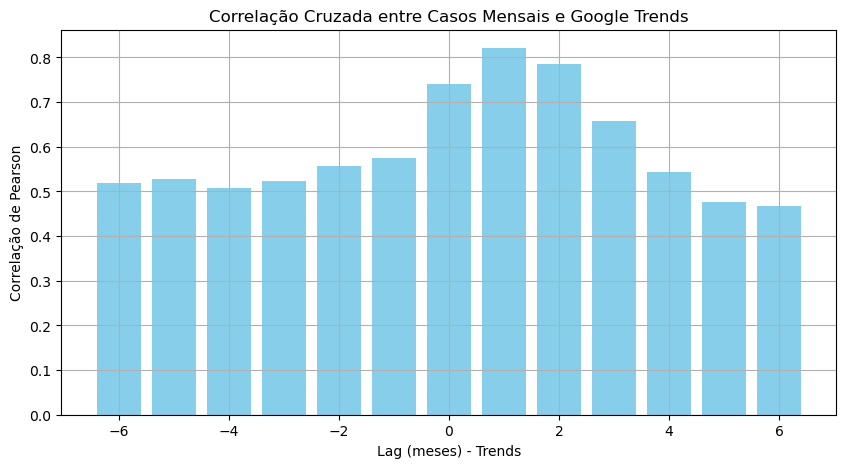

In [31]:
import numpy as np

def cross_correlation(x, y, lag_max=12):
    lags = range(-lag_max, lag_max+1)
    ccs = [x.corr(y.shift(lag)) for lag in lags]
    return lags, ccs

lags, ccs = cross_correlation(aligned['Casos_Mensais'], aligned['Trends'], lag_max=6)

plt.figure(figsize=(10,5))
plt.bar(lags, ccs, color='skyblue')
plt.title('Correlação Cruzada entre Casos Mensais e Google Trends')
plt.xlabel('Lag (meses) - Trends')
plt.ylabel('Correlação de Pearson')
plt.grid(True)
plt.show()

"Se o pico for em lag positivo: 'Este resultado sugere que o aumento no volume de buscas por 'COVID-19' tende a preceder o aumento no número de casos confirmados em São Paulo em [Lag X] meses. Tal antecipação pode ser explicada pelo fato de que indivíduos podem buscar informações sobre a doença, sintomas ou testes antes de um diagnóstico formal ou antes que os dados oficiais sejam consolidados e reportados. Isso valida a Hipótese H2, indicando que o Google Trends possui um potencial preditivo para a vigilância epidemiológica.'"